Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

# Model Zoo -- ResNet-18 MNIST Digits Classifier with Data Parallelism

### Network Architecture

The network in this notebook is an implementation of the ResNet-18 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  


References
    
- [1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). ([CVPR Link](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html))

- [2] http://yann.lecun.com/exdb/mnist/

The following figure illustrates residual blocks with skip connections such that the input passed via the shortcut matches the dimensions of the main path's output, which allows the network to learn identity functions.

![](../images/resnets/resnet-ex-1-1.png)


The ResNet-18 architecture actually uses residual blocks with skip connections such that the input passed via the shortcut matches is resized to dimensions of the main path's output. Such a residual block is illustrated below:

![](../images/resnets/resnet-ex-1-2.png)

For a more detailed explanation see the other notebook, [resnet-ex-1.ipynb](resnet-ex-1.ipynb).

## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Model Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
GRAYSCALE = True

### MNIST Dataset

In [4]:
##########################
### MNIST DATASET
##########################
root_dir = '/content/drive/My Drive/RND_SEM8'

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root=root_dir,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root=root_dir,
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12697335.59it/s]


Extracting /content/drive/My Drive/RND_SEM8/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/RND_SEM8/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 329932.46it/s]


Extracting /content/drive/My Drive/RND_SEM8/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/RND_SEM8/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3203372.11it/s]


Extracting /content/drive/My Drive/RND_SEM8/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/RND_SEM8/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8065422.85it/s]


Extracting /content/drive/My Drive/RND_SEM8/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/RND_SEM8/MNIST/raw

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [5]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


The following code cell that implements the ResNet-34 architecture is a derivative of the code provided at https://pytorch.org/docs/0.4.0/_modules/torchvision/models/resnet.html.

In [6]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock,
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [7]:
torch.manual_seed(RANDOM_SEED)

model2 = resnet18(NUM_CLASSES)
model2.to(DEVICE)
model2.load_state_dict(torch.load('/content/drive/MyDrive/RND_SEM8/mnist-logistic.pth', map_location=torch.device('cpu')))
model2.state_dict()

optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)

## Training

In [8]:

def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

"""
start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx,
                     len(train_loader), cost))


    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS,
              compute_accuracy(model, train_loader, device=DEVICE)))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
"""

"\nstart_time = time.time()\nfor epoch in range(NUM_EPOCHS):\n\n    model.train()\n    for batch_idx, (features, targets) in enumerate(train_loader):\n\n        features = features.to(DEVICE)\n        targets = targets.to(DEVICE)\n\n        ### FORWARD AND BACK PROP\n        logits, probas = model(features)\n        cost = F.cross_entropy(logits, targets)\n        optimizer.zero_grad()\n\n        cost.backward()\n\n        ### UPDATE MODEL PARAMETERS\n        optimizer.step()\n\n        ### LOGGING\n        if not batch_idx % 50:\n            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'\n                   %(epoch+1, NUM_EPOCHS, batch_idx,\n                     len(train_loader), cost))\n\n\n    model.eval()\n    with torch.set_grad_enabled(False): # save memory during inference\n        print('Epoch: %03d/%03d | Train: %.3f%%' % (\n              epoch+1, NUM_EPOCHS,\n              compute_accuracy(model, train_loader, device=DEVICE)))\n\n    print('Time elapsed: %.2f min' 

## Evaluation

In [9]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model2, test_loader, device=DEVICE)))

Test accuracy: 99.17%


In [10]:
#torch.save(model.state_dict(), 'mnist-logistic.pth')

In [11]:
"""
model2 = resnet18(NUM_CLASSES)
model2.to(DEVICE)
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()
"""

"\nmodel2 = resnet18(NUM_CLASSES)\nmodel2.to(DEVICE)\nmodel2.load_state_dict(torch.load('mnist-logistic.pth'))\nmodel2.state_dict()\n"

(28, 28)


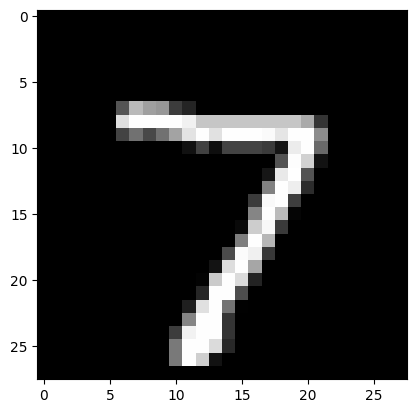

In [12]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
print(nhw_img.shape)
plt.imshow(nhw_img, cmap='gray');


torch.Size([1, 28, 28])
torch.Size([28, 28, 1])
(28, 28)


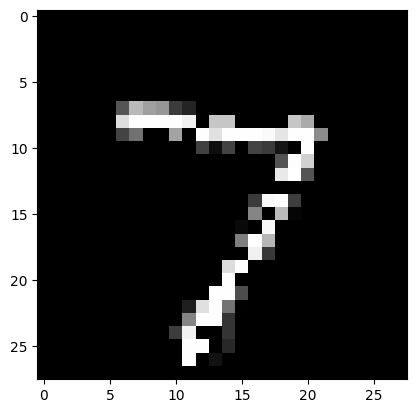

In [13]:
dropout = nn.Dropout(p=0.3)
dropout_img = dropout(features[0])
print(dropout_img.shape)
d_img = np.transpose(dropout_img,axes=(1,2,0))
print(d_img.shape)
d_img = np.squeeze(d_img.numpy(),axis=2)
print(d_img.shape)
plt.imshow(d_img, cmap = 'gray')

In [14]:
model2.eval()
logits, probas = model2(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%


In [15]:
def calculate_softmax(predicted_labels):
    # Calculate e^x for each predicted label
    exp_values = np.exp(predicted_labels)

    # Calculate the sum of e^x values
    sum_exp_values = np.sum(exp_values)

    # Calculate softmax probabilities
    softmax_probs = exp_values / sum_exp_values

    return softmax_probs

def apply_dropout_to_image(model, image, num_dropout_iterations, prob=0.5):
    """
    Apply dropout to a single image multiple times and obtain predictions.

    Args:
    - model: The trained PyTorch model
    - image: The input image tensor
    - num_dropout_iterations: Number of times dropout should be applied
    - prob: Dropout probability

    Returns:
    - predictions: List of predicted labels for each dropout iteration
    """
    # Set the model to evaluation mode
    model.eval()

    # Define a dropout layer
    dropout = nn.Dropout(p=prob)  # Adjust the dropout probability as needed

    # Move the image tensor to the appropriate device
    image = image.to(DEVICE)

    # Create a list to store predictions
    predictions = []
    dropout_images = []


    # Apply dropout multiple times
    for _ in range(num_dropout_iterations):
        # Apply dropout to the input image
        image_with_dropout = dropout(image)
        # Forward pass through the model with dropout
        logits, _ = model(image_with_dropout)

        # Get predictions
        _, predicted_label = torch.max(logits, 1)

        # Append predicted label to the predictions list
        predictions.append(predicted_label.item())
        dropout_images.append(image_with_dropout.detach().cpu().numpy())

    probabilities = calculate_softmax(predictions)

    return predictions,dropout_images, probabilities

# Example usage:
# predictions = apply_dropout_to_image(model2, test_image, num_dropout_iterations=30)


In [16]:
# Choose an index for the image
image_index = 8  # Choose the index of the image you want to visualize

# Get the image and its corresponding label from the test dataset
image, label = test_dataset[image_index]

# Apply dropout once to the image and obtain predictions
predictions,dropout_images, probabilities = apply_dropout_to_image(model2, image.unsqueeze(0), num_dropout_iterations=30,prob =0.7)

print("Predictions:", predictions)
print("probabilities:", probabilities)

Predictions: [5, 5, 7, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 3, 5, 5, 4, 8, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5]
probabilities: [0.01258615 0.01258615 0.09299978 0.01258615 0.01258615 0.01258615
 0.01258615 0.25279962 0.01258615 0.01258615 0.01258615 0.01258615
 0.01258615 0.01258615 0.00170335 0.01258615 0.01258615 0.00463019
 0.25279962 0.01258615 0.01258615 0.01258615 0.01258615 0.01258615
 0.01258615 0.09299978 0.01258615 0.01258615 0.01258615 0.01258615]


Predictions: [5]
probabilities: [1.]
Predicted Label: 5


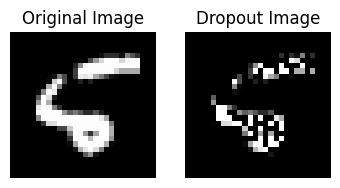

In [17]:
# Choose an index for the image
image_index = 8  # Choose the index of the image you want to visualize

# Get the image and its corresponding label from the test dataset
image, label = test_dataset[image_index]

# Apply dropout once to the image and obtain predictions
predictions,dropout_images, probabilities = apply_dropout_to_image(model2, image.unsqueeze(0), num_dropout_iterations=1,prob =0.5)

print("Predictions:", predictions)
print("probabilities:", probabilities)
# Convert the image tensor to a numpy array for visualization
image_np = image.squeeze().numpy()

# Convert the dropout-affected image tensor to a numpy array for visualization
dropout_image_np = dropout_images[0].squeeze()

# Get the predicted label
predicted_label = predictions[0]

# Define the class labels for MNIST
class_labels = [str(i) for i in range(10)]

# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display the dropout-affected image
plt.subplot(1, 3, 2)
plt.imshow(dropout_image_np, cmap='gray')
plt.title('Dropout Image')
plt.axis('off')


# Print the predicted label
print('Predicted Label:', predicted_label)


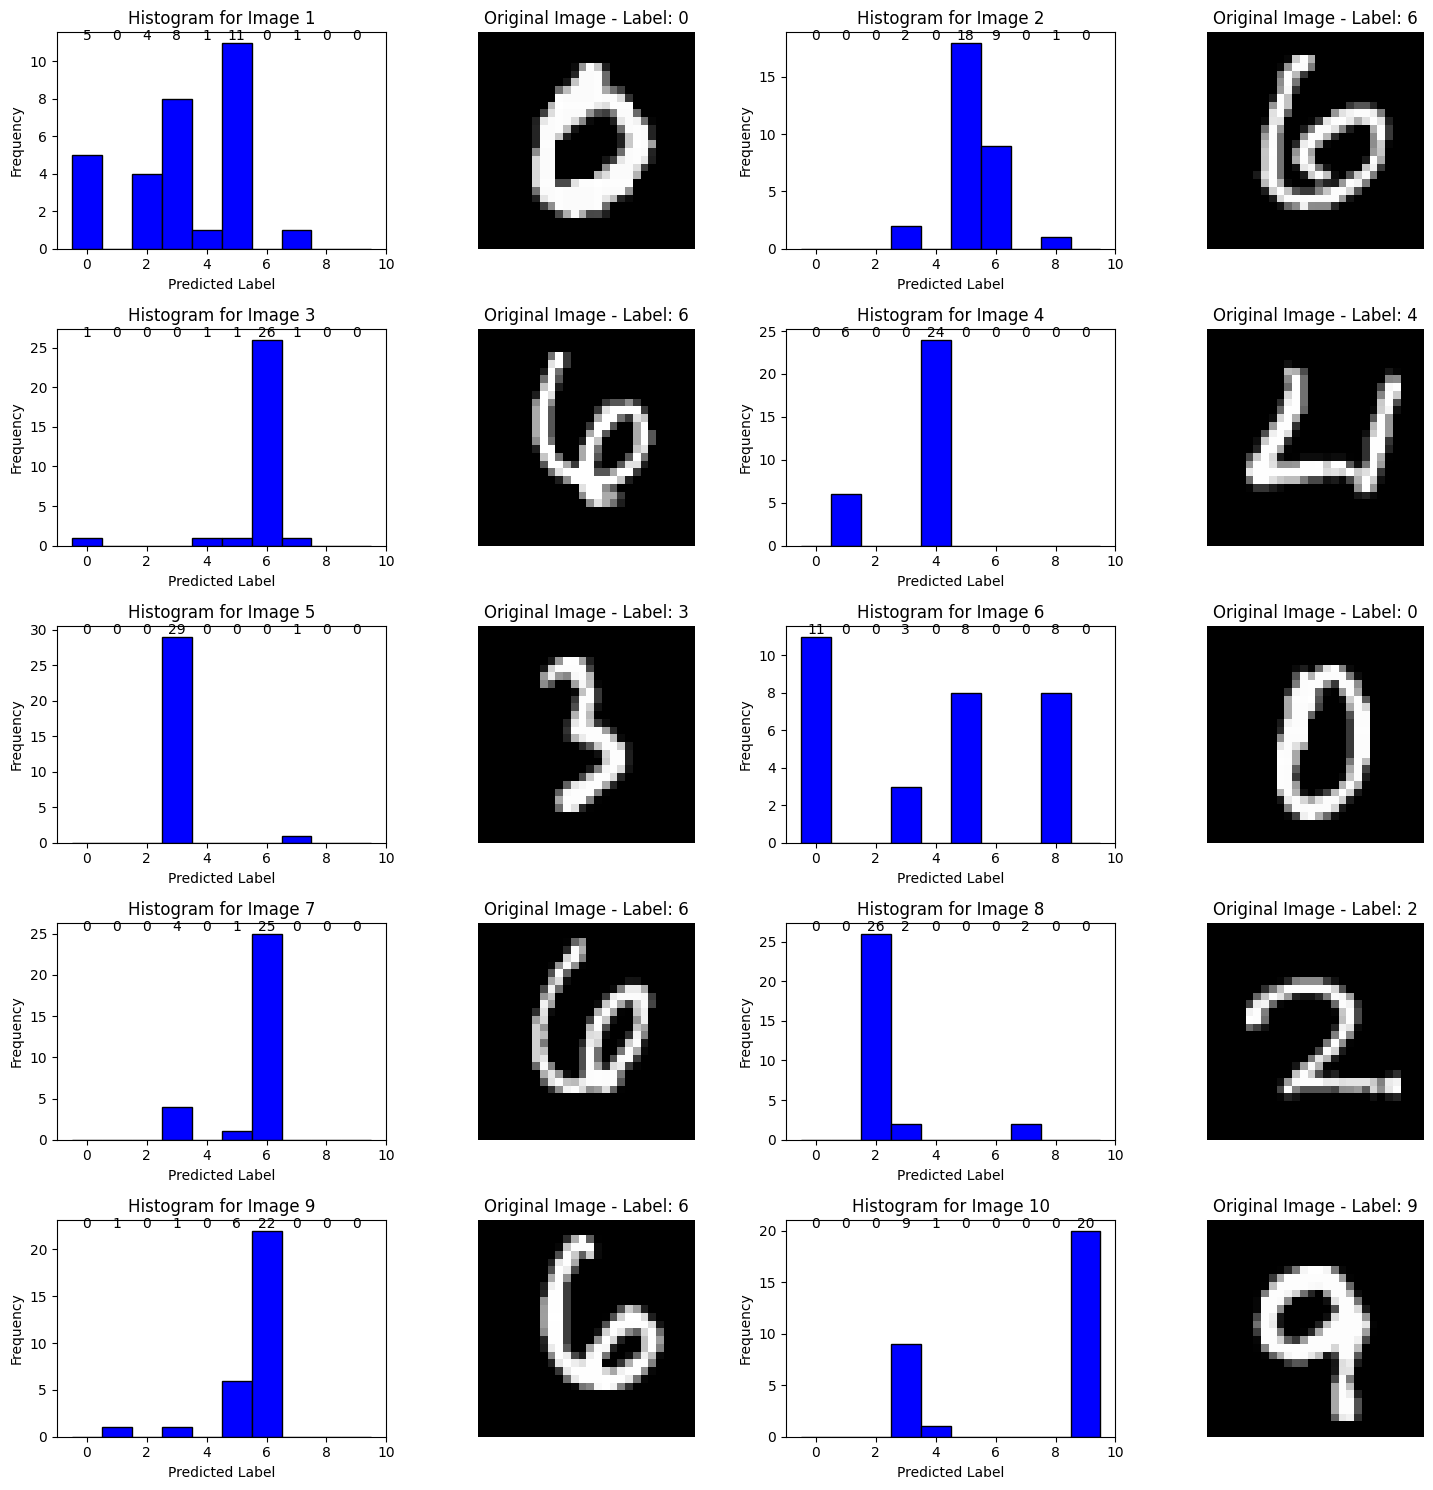

In [18]:
# Set the number of dropout iterations
num_dropout_iterations = 30

# Choose 10 random indices for the images
image_indices = [3, 11, 22, 33, 44, 55, 66, 77, 88, 99]  # You can change these indices as needed

# Create a figure to display the images and histograms
plt.figure(figsize=(15, 15))

# Iterate over the chosen image indices
for i, image_index in enumerate(image_indices, start=1):
    # Get the image and its corresponding label from the test dataset
    image, label = test_dataset[image_index]

    # Apply dropout multiple times to the image and obtain predictions
    predictions, _ ,_= apply_dropout_to_image(model2, image.unsqueeze(0), num_dropout_iterations)

    # Plot the original image
    plt.subplot(5, 4, 2*i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image - Label: {}'.format(label))
    plt.axis('off')

    # Plot the histogram for the predictions
    plt.subplot(5, 4, 2*i-1)
    plt.hist(predictions, bins=np.arange(11) - 0.5, color='blue', edgecolor='black')
    plt.title('Histogram for Image {}'.format(i))
    plt.xlabel('Predicted Label')
    plt.ylabel('Frequency')


    # Calculate the frequency of each predicted label
    label_counts = [predictions.count(j) for j in range(10)]

    # Add labels with counts on top of each bar in the histogram
    for k in range(10):
        plt.text(k, max(label_counts), str(label_counts[k]), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [19]:

# Set the number of dropout iterations
num_dropout_iterations = 30

# Dictionary to store image IDs and their corresponding entropy values
entropy_dict = {}

# Iterate through the test dataset
for image_index in range(len(test_dataset)):
    # Get the image and its corresponding label from the test dataset
    image, label = test_dataset[image_index]

    # Apply dropout multiple times to the image and obtain maximum probability values
    _, _, probabilities = apply_dropout_to_image(model2, image.unsqueeze(0), num_dropout_iterations)

    # Calculate entropy using the maximum probability values
    probas = np.array(probabilities)
    entropy = -np.sum(probas * np.log2(probas + 1e-10))  # Calculate entropy
    entropy_dict[image_index] = entropy  # Store the image ID and its entropy in the dictionary

# Print the dictionary containing image IDs and their corresponding entropy values
print(entropy_dict)


{0: 4.113962382593296, 1: 0.6014672359246306, 2: 1.8206559842748826, 3: 2.699090369298092, 4: 4.894239239712593, 5: 3.0261339575879145, 6: 2.669054384585338, 7: 4.852793668871104, 8: 4.906890591280434, 9: 4.293419123725405, 10: 4.30530033444368, 11: 4.041408506058582, 12: 4.050017033648915, 13: 2.5888741328358447, 14: 2.1198751295510045, 15: 4.727395681992225, 16: 4.375402038535589, 17: 4.670193258386684, 18: 1.3395323599944535, 19: 3.8461970020510146, 20: 4.090662900377231, 21: 3.8506800811527837, 22: 4.253371614256385, 23: 4.878100803987288, 24: 2.362446606604403, 25: 3.6216831961636236, 26: 4.862534244378383, 27: 2.61648889764265, 28: 4.0676677234318985, 29: 2.8071282228183083, 30: 4.906890591280434, 31: 3.333417150570898, 32: 4.906890591280434, 33: 4.65859378059087, 34: 3.577752078355533, 35: 4.725283266081451, 36: 4.8141509935517215, 37: 3.03483624702473, 38: 4.651292257089051, 39: 3.151940730024214, 40: 3.457711611531275, 41: 4.448543005755757, 42: 2.0137844298050576, 43: 4.83464

In [38]:
# Convert the dictionary to a DataFrame
entropy_df = pd.DataFrame(list(entropy_dict.items()), columns=['Image_ID', 'Entropy'])

# Sort the DataFrame by entropy values in ascending order
entropy_df = entropy_df.sort_values(by='Entropy', ascending=False)

# Print the sorted DataFrame
display(entropy_df)


,Image_ID,Entropy
4230,4230,4.906891
6593,6593,4.906891
887,887,4.906891
897,897,4.906891
894,894,4.906891
...,...,...
2519,2519,0.497424
8615,8615,0.459952
2541,2541,0.323691
4098,4098,0.311553


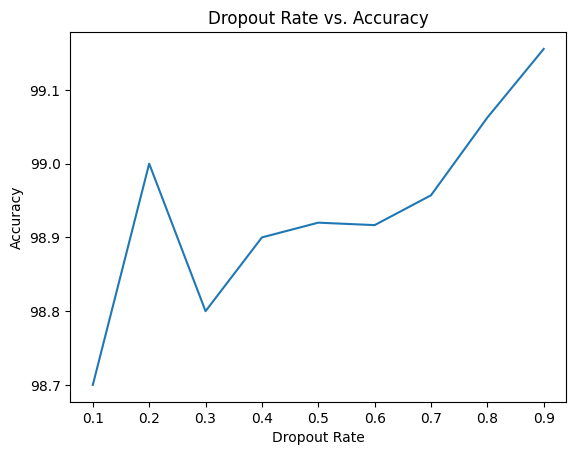

In [39]:
from torch.utils.data import DataLoader, Subset
# Initialize lists to store accuracy and dropout rate
accuracies = []
dropout_rates = []

# Define the dropout rates to iterate over
dropout_rate_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Loop through the dropout rates
for drop_rate in dropout_rate_range:
    # Calculate the number of images to drop
    num_images = len(entropy_df)
    num_drops = int(num_images * drop_rate)
    # Get the remaining rows after dropping the specified percentage
    entropy_df_remaining = entropy_df.iloc[:-num_drops]
    # Get the remaining image IDs
    remaining_image_ids = entropy_df_remaining['Image_ID'].tolist()

    # Create a new test dataset excluding the dropped image IDs
    new_test_dataset = Subset(test_dataset, [idx for idx in range(len(test_dataset)) if idx not in remaining_image_ids])

    # Create a data loader for the new test dataset
    new_test_loader = DataLoader(new_test_dataset, batch_size=128, shuffle=False)

    # Compute the accuracy of the model on the new test dataset
    accuracy = compute_accuracy(model2, new_test_loader, device)

    # Append accuracy and dropout rate to the lists
    accuracies.append(accuracy.item())
    dropout_rates.append(drop_rate)

# Plot dropout rate vs. accuracy
plt.plot(dropout_rates, accuracies)
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.title('Dropout Rate vs. Accuracy')
plt.show()


In [28]:
def add_gaussian_noise(image, mean=0, stddev=0.5):
    """
    Add Gaussian noise to an image.

    Args:
    - image (Tensor): Input image tensor.
    - mean (float): Mean of the Gaussian noise.
    - stddev (float): Standard deviation of the Gaussian noise.

    Returns:
    - noisy_image (Tensor): Image tensor with added Gaussian noise.
    """
    # Generate Gaussian noise
    noisy_image = image + torch.randn_like(image) * stddev + mean

    noisy_image = torch.clamp(noisy_image, 0, 1)

    return noisy_image


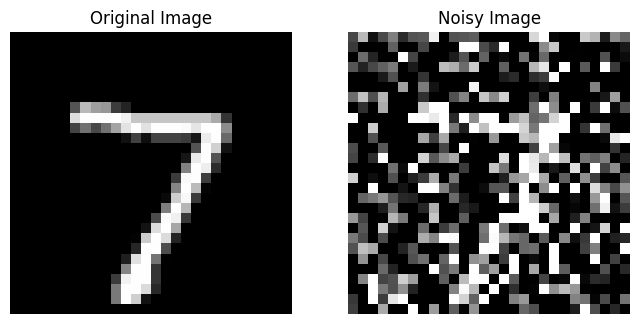

In [30]:
# Select one image from the test dataset
image, label = test_dataset[0]  # Change the index as needed

noisy_image = add_gaussian_noise(image, stddev= 0.7)

# Plot the original and noisy images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image.squeeze(), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.show()


In [31]:

# Add Gaussian noise to each image in the test dataset and calculate model accuracy
noisy_test_dataset = []

for image, label in test_dataset:
    # Add Gaussian noise to the image
    noisy_image = add_gaussian_noise(image)
    # Append the noisy image and label to the noisy test dataset
    noisy_test_dataset.append((noisy_image, label))

# Create a DataLoader for the noisy test dataset
noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=128, shuffle=False)

# Calculate model accuracy on the noisy test dataset
accuracy = compute_accuracy(model2, noisy_test_loader, DEVICE)
print("Model accuracy on noisy test dataset: {:.2f}%".format(accuracy))


Model accuracy on noisy test dataset: 40.61%


In [42]:
noise_levels = [0.0, 0.2, 0.4, 0.6, 0.8 ,1.0]

# Dictionary to store image IDs and their corresponding entropy values
entropy_dict = {}
# Iterate through the test dataset
for noise_level in noise_levels:
  predictions = []
  for image_index in range(len(test_dataset)):
      # Get the image and its corresponding label from the test dataset
      image, label = test_dataset[image_index]

      # Apply dropout multiple times to the image and obtain maximum probability values
      noisy_image = add_gaussian_noise(image, stddev =noise_level).to(DEVICE)
      # Forward pass through the model with dropout
      logits, _ = model2(noisy_image.unsqueeze(0))

      # Get predictions
      _, predicted_label = torch.max(logits, 1)

      # Append predicted label to the predictions list
      predictions.append(predicted_label.item())
  probabilities = calculate_softmax(predictions)

  # Calculate entropy using the maximum probability values
  probas = np.array(probabilities)
  entropy = -np.sum(probas * np.log2(probas + 1e-10))  # Calculate entropy
  entropy_dict[noise_level] = entropy  # Store the image ID and its entropy in the dictionary

# Print the dictionary containing image IDs and their corresponding entropy values
print(entropy_dict)


{0.0: 11.450653064066373, 0.2: 11.560325395765677, 0.4: 12.310057832797396, 0.6: 12.984829669861163, 0.8: 13.18785656709155, 1.0: 13.24726671553686}


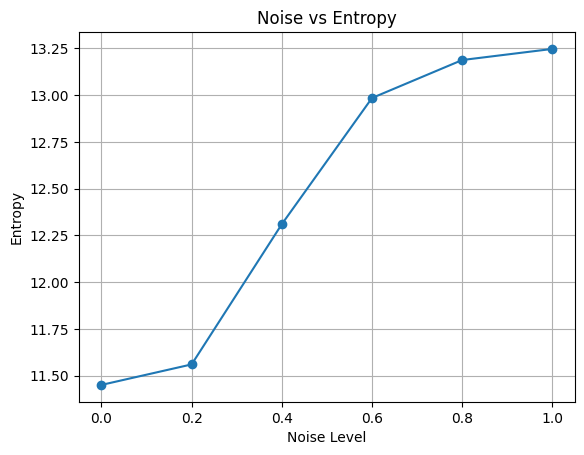

In [43]:

# Extract noise levels and entropy values from the entropy_dict
noise_levels = list(entropy_dict.keys())
entropies = list(entropy_dict.values())

# Plot noise vs entropy curve
plt.plot(noise_levels, entropies, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Entropy')
plt.title('Noise vs Entropy')
plt.grid(True)
plt.show()


In [ ]:
import torch.nn as nn

def apply_dropout_to_image(model, image, num_dropout_iterations, prob=0.5):
    """
    Apply dropout to a single image multiple times and obtain predictions, dropout images, and probability values.

    Args:
    - model: The trained PyTorch model
    - image: The input image tensor
    - num_dropout_iterations: Number of times dropout should be applied
    - prob: Dropout probability

    Returns:
    - predictions: List of predicted labels for each dropout iteration
    - dropout_images: List of dropout-affected images for each dropout iteration
    - probas_values: List of probability values for each dropout iteration
    """
    # Set the model to evaluation mode
    model.eval()

    # Define a dropout layer
    dropout = nn.Dropout(p=prob)  # Adjust the dropout probability as needed

    # Move the image tensor to the appropriate device
    image = image.to(DEVICE)
    # Create lists to store predictions, dropout images, and probability values
    predictions = []
    dropout_images = []
    prob = []

    # Apply dropout multiple times
    for _ in range(num_dropout_iterations):
        # Apply dropout to the input image
        image_with_dropout = dropout(image)
        # Forward pass through the model with dropout
        logits, probas = model(image_with_dropout)

        # Get predictions
        _, predicted_label = torch.max(probas, 1)

        # Append predicted label to the predictions list
        predictions.append(predicted_label.item())
        max_prob = torch.max(probas).item()
        prob.append(max_prob)

        # Append dropout-affected image to the dropout_images list
        dropout_images.append(image_with_dropout.detach().cpu().numpy())  # Detach and move to CPU



    return predictions, dropout_images, prob

# Example usage:
# predictions, dropout_images, probas_values = apply_dropout_to_image(model2, test_image, num_dropout_iterations=30)


Predicted Label: 5


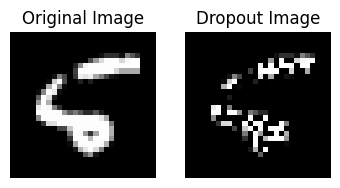

In [ ]:
# Choose an index for the image
image_index = 8  # Choose the index of the image you want to visualize

# Get the image and its corresponding label from the test dataset
image, label = test_dataset[image_index]

# Apply dropout once to the image and obtain predictions
predictions, dropout_images,probas_values = apply_dropout_to_image(model2, image.unsqueeze(0), num_dropout_iterations=1,prob =0.5)

# Convert the image tensor to a numpy array for visualization
image_np = image.squeeze().numpy()

# Convert the dropout-affected image tensor to a numpy array for visualization
dropout_image_np = dropout_images[0].squeeze()

# Get the predicted label
predicted_label = predictions[0]

# Define the class labels for MNIST
class_labels = [str(i) for i in range(10)]

# Display the original image
plt.subplot(1, 3, 1)
plt.imshow(image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display the dropout-affected image
plt.subplot(1, 3, 2)
plt.imshow(dropout_image_np, cmap='gray')
plt.title('Dropout Image')
plt.axis('off')


# Print the predicted label
print('Predicted Label:', predicted_label)


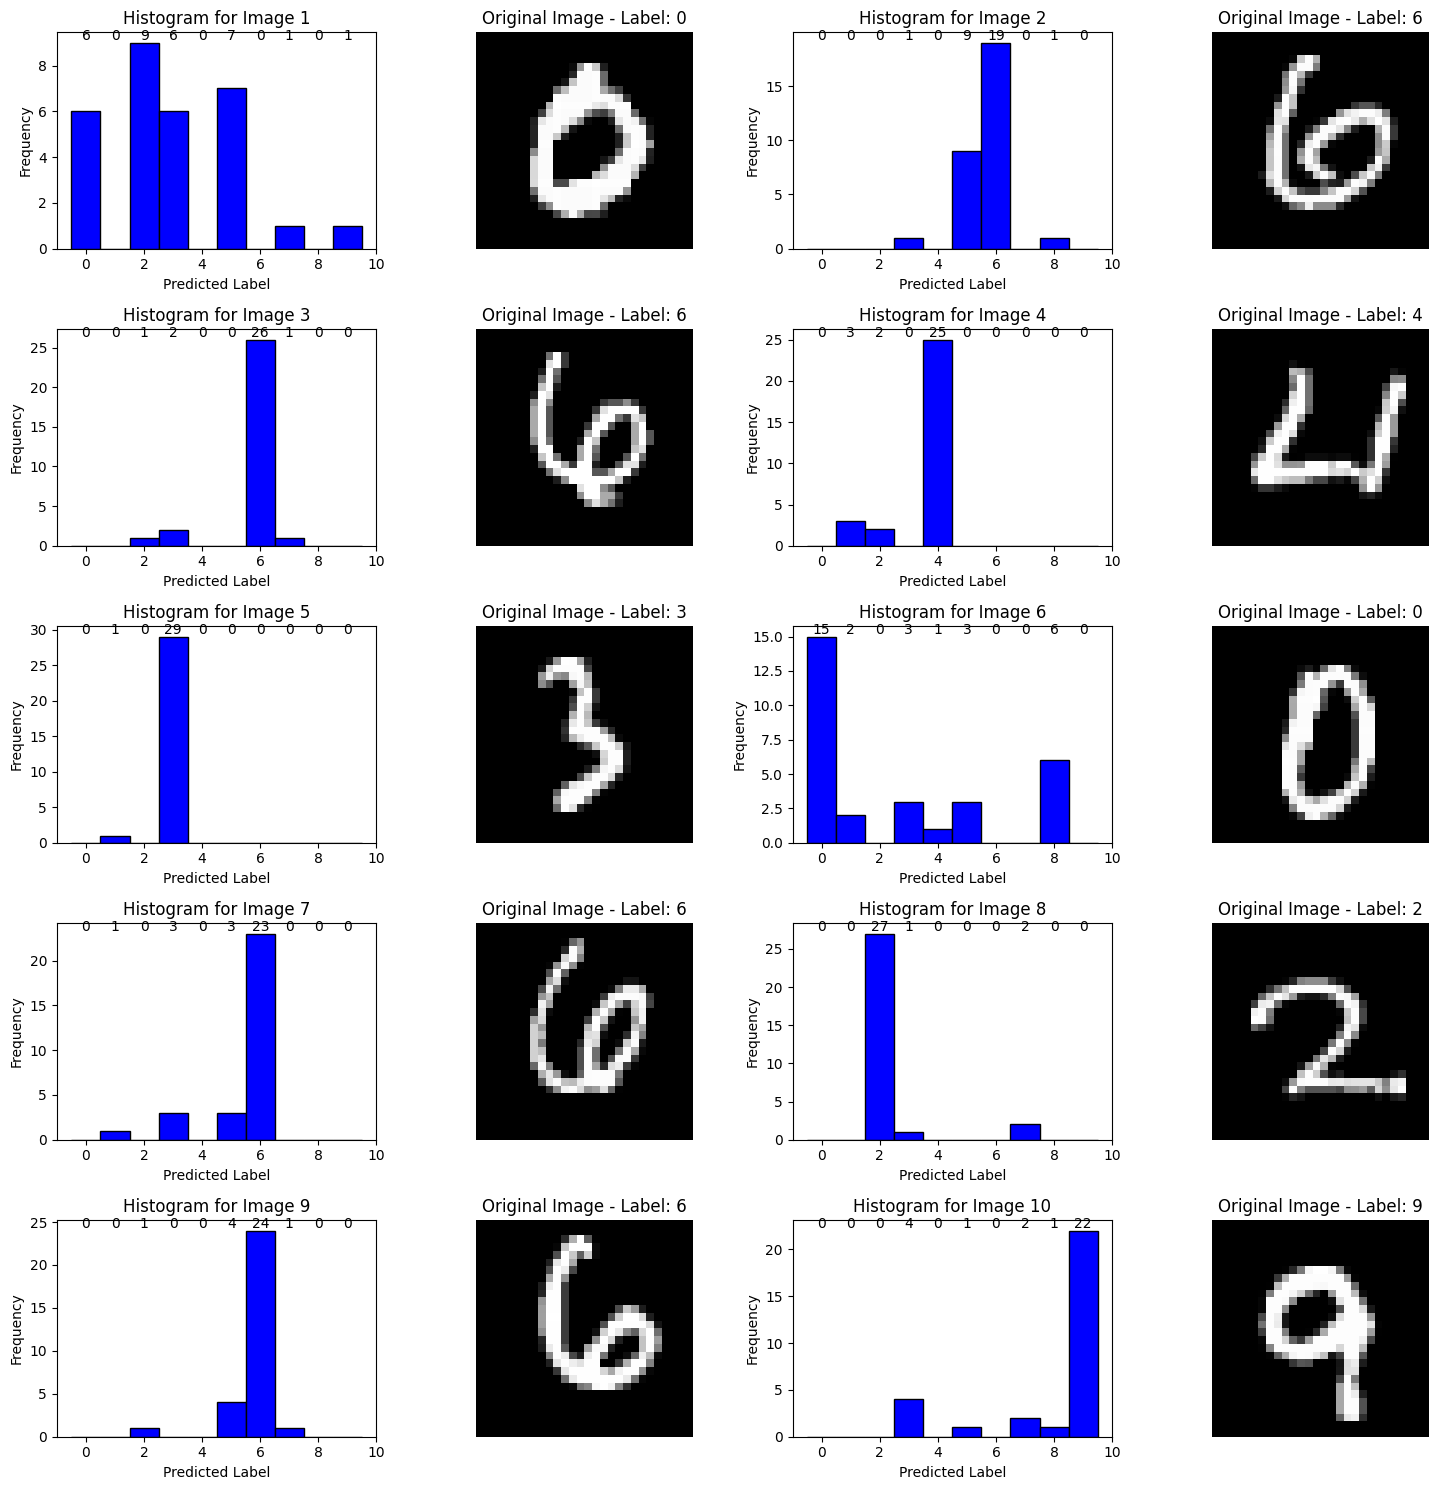

In [ ]:
# Set the number of dropout iterations
num_dropout_iterations = 30

# Choose 10 random indices for the images
image_indices = [3, 11, 22, 33, 44, 55, 66, 77, 88, 99]  # You can change these indices as needed

# Create a figure to display the images and histograms
plt.figure(figsize=(15, 15))

# Iterate over the chosen image indices
for i, image_index in enumerate(image_indices, start=1):
    # Get the image and its corresponding label from the test dataset
    image, label = test_dataset[image_index]

    # Apply dropout multiple times to the image and obtain predictions
    predictions, _ ,_= apply_dropout_to_image(model2, image.unsqueeze(0), num_dropout_iterations)

    # Plot the original image
    plt.subplot(5, 4, 2*i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image - Label: {}'.format(label))
    plt.axis('off')

    # Plot the histogram for the predictions
    plt.subplot(5, 4, 2*i-1)
    plt.hist(predictions, bins=np.arange(11) - 0.5, color='blue', edgecolor='black')
    plt.title('Histogram for Image {}'.format(i))
    plt.xlabel('Predicted Label')
    plt.ylabel('Frequency')


    # Calculate the frequency of each predicted label
    label_counts = [predictions.count(j) for j in range(10)]

    # Add labels with counts on top of each bar in the histogram
    for k in range(10):
        plt.text(k, max(label_counts), str(label_counts[k]), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

# Set the number of dropout iterations
num_dropout_iterations = 30

# Dictionary to store image IDs and their corresponding entropy values
entropy_dict = {}

# Iterate through the test dataset
for image_index in range(len(test_dataset)):
    # Get the image and its corresponding label from the test dataset
    image, label = test_dataset[image_index]

    # Apply dropout multiple times to the image and obtain maximum probability values
    _, _, max_probas = apply_dropout_to_image(model2, image.unsqueeze(0), num_dropout_iterations)

    # Calculate entropy using the maximum probability values
    max_probas = np.array(max_probas)
    entropy = -np.sum(max_probas * np.log2(max_probas + 1e-10))  # Calculate entropy
    entropy_dict[image_index] = entropy  # Store the image ID and its entropy in the dictionary

# Print the dictionary containing image IDs and their corresponding entropy values
print(entropy_dict)


{0: 3.2196349101706137, 1: 5.448887220312986, 2: 9.319495999286096, 3: 8.443471436869432, 4: 3.356321854305456, 5: 7.380772315891515, 6: 8.545041711941655, 7: 2.4002609605049026, 8: 3.1123960442207763, 9: 5.404634070434627, 10: 9.466760040213812, 11: 8.855565611767313, 12: 5.752317510224479, 13: 5.0619761888369785, 14: 4.273885366541761, 15: 5.1094959679512435, 16: 5.9018643177265, 17: 1.0212958693968113, 18: 3.3306270313304425, 19: 2.9951088993566533, 20: 6.115170929639639, 21: 2.658977440283822, 22: 8.097948598262684, 23: 1.486012038719341, 24: 6.174820865035938, 25: 9.171612651828374, 26: 0.9582928414102416, 27: 0.5527586625604942, 28: 5.483174823269789, 29: 5.722415166971144, 30: 0.0003485955776834549, 31: 10.431028872779317, 32: 0.5562439514620495, 33: 4.6824884833073, 34: 3.2150682255575713, 35: 4.103861934480832, 36: 2.4512728928661254, 37: 6.740585855803472, 38: 4.616382634296637, 39: 5.415034798456018, 40: 8.128916432843905, 41: 5.692788906612431, 42: 1.7528054981788832, 43: 3

In [ ]:
# Convert the dictionary to a DataFrame
entropy_df = pd.DataFrame(list(entropy_dict.items()), columns=['Image_ID', 'Entropy'])

# Sort the DataFrame by entropy values in ascending order
entropy_df = entropy_df.sort_values(by='Entropy', ascending=True)

# Print the sorted DataFrame
display(entropy_df)


,Image_ID,Entropy
4973,4973,0.000041
9235,9235,0.000048
5585,5585,0.000088
9445,9445,0.000122
5418,5418,0.000139
...,...,...
9845,9845,12.694053
1868,1868,12.710814
8887,8887,12.724650
7217,7217,13.509852


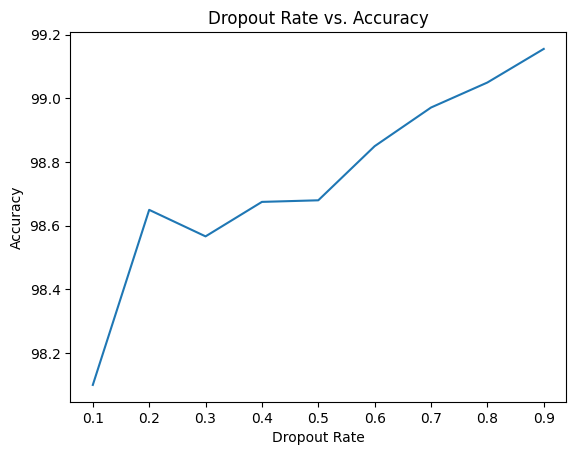

In [ ]:
from torch.utils.data import DataLoader, Subset

# Initialize lists to store accuracy and dropout rate
accuracies = []
dropout_rates = []

# Define the dropout rates to iterate over
dropout_rate_range = [0.1 * i for i in range(1, 1)]

# Loop through the dropout rates
for drop_rate in dropout_rate_range:
    # Calculate the number of images to drop
    num_images = len(entropy_df)
    num_drops = int(num_images * drop_rate)

    # Get the remaining rows after dropping the specified percentage
    entropy_df_remaining = entropy_df.iloc[:-num_drops]

    # Get the remaining image IDs
    remaining_image_ids = entropy_df_remaining['Image_ID'].tolist()

    # Create a new test dataset excluding the dropped image IDs
    new_test_dataset = Subset(test_dataset, [idx for idx in range(len(test_dataset)) if idx not in remaining_image_ids])

    # Create a data loader for the new test dataset
    new_test_loader = DataLoader(new_test_dataset, batch_size=128, shuffle=False)

    # Compute the accuracy of the model on the new test dataset
    accuracy = compute_accuracy(model2, new_test_loader, device)

    # Append accuracy and dropout rate to the lists
    accuracies.append(accuracy.item())
    dropout_rates.append(drop_rate)

# Plot dropout rate vs. accuracy
plt.plot(dropout_rates, accuracies)
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.title('Dropout Rate vs. Accuracy')
plt.show()


In [ ]:
# Set the model to evaluation mode
model2.eval()

# Dictionary to store image IDs and their corresponding list of probability values
probas_dict = {}

# Iterate through the indices of the test dataset
for idx in range(len(test_dataset)):
    image, label = test_dataset[idx]  # Get the image and its label
    image_id = idx  # Use the index as the image ID

    # List to store probability values for each dropout iteration
    probas_list = []

    # Apply dropout 30 times and get probability values each time
    for _ in range(30):
        with torch.no_grad():  # Disable gradient calculation
            dropout_image = F.dropout(image.unsqueeze(0).to(device), p=0.5, training=True)  # Apply dropout to the image
            logits, probas = model2(dropout_image)  # Forward pass with dropout
            probas_list.append(probas.squeeze().tolist())  # Append probability values to the list

    # Store the image ID and its list of probability values in the dictionary
    probas_dict[image_id] = probas_list

# Dictionary to store image IDs and their corresponding entropy values
entropy_dict = {}

# Calculate entropy for each image using the list of probability values
for image_id, probas_list in probas_dict.items():
    # Concatenate the probability values into a tensor along the second dimension
    probas_tensor = torch.tensor(probas_list)

    # Calculate the entropy using the formula
    entropy = -torch.sum(torch.log(probas_tensor + 1e-10), dim=0)

    # Store the image ID and its entropy value in the dictionary
    entropy_dict[image_id] = entropy.tolist()

# Print the dictionary containing image IDs and their corresponding entropy values
print(entropy_dict)


{0: [420.3676452636719, 331.93206787109375, 272.24774169921875, 83.00602722167969, 298.1940002441406, 329.9183349609375, 465.5788879394531, 52.07040786743164, 348.69512939453125, 244.18569946289062], 1: [310.8109130859375, 82.06354522705078, 61.75010299682617, 151.53053283691406, 257.5299072265625, 272.585693359375, 234.68441772460938, 186.6968994140625, 243.45208740234375, 223.29881286621094], 2: [197.1383056640625, 87.68880462646484, 165.71234130859375, 70.47514343261719, 180.4882354736328, 115.04243469238281, 175.88058471679688, 137.0177764892578, 129.66693115234375, 132.34727478027344], 3: [91.86854553222656, 227.07424926757812, 115.28376007080078, 123.130126953125, 191.4093780517578, 120.7572021484375, 191.42718505859375, 193.43878173828125, 135.8264923095703, 156.6825408935547], 4: [375.67926025390625, 163.74388122558594, 273.1271057128906, 302.28302001953125, 8.777950286865234, 254.31553649902344, 254.55499267578125, 206.8168487548828, 281.2216796875, 167.42620849609375], 5: [21

In [ ]:
# Set the model to evaluation mode
model2.eval()

# Dictionary to store image IDs and their corresponding list of probability values
probas_dict = {}

# Iterate through the test loader
for batch_idx, (images, image_ids) in enumerate(test_loader):
    for i in range(images.size(0)):  # Loop through each image in the batch
        image = images[i:i+1].to(device)  # Get the current image and move it to the device
        image_id = image_ids[i].item()  # Get the ID of the current image

        # List to store probability values for each dropout iteration
        probas_list = []

        # Apply dropout 30 times and get probability values each time
        for _ in range(30):
            with torch.no_grad():  # Disable gradient calculation
                dropout_image = F.dropout(image, p=0.5, training=True)  # Apply dropout to the image
                logits, probas = model2(dropout_image)  # Forward pass with dropout
                probas_list.append(probas.squeeze().tolist())  # Append probability values to the list

        # Store the image ID and its list of probability values in the dictionary
        probas_dict[image_id] = probas_list

# Dictionary to store image IDs and their corresponding entropy values
entropy_dict = {}

# Calculate entropy for each image using the list of probability values
for image_id, probas_list in probas_dict.items():
    # Convert the list of probability values to a tensor
    probas_tensor = torch.tensor(probas_list)

    # Calculate entropy using the formula
    entropy = -torch.sum(torch.log(probas_tensor + 1e-10), dim=1)

    # Calculate the mean entropy across all dropout iterations
    mean_entropy = torch.mean(entropy).item()

    # Store the image ID and its mean entropy in the dictionary
    entropy_dict[image_id] = mean_entropy

# Print the dictionary containing image IDs and their corresponding entropy values
print(entropy_dict)


{7: 110.42943572998047, 2: 74.0753173828125, 1: 53.121665954589844, 0: 59.02490997314453, 4: 87.55482482910156, 9: 55.52040481567383, 5: 103.49825286865234, 6: 63.65601348876953, 3: 124.63002014160156, 8: 135.28790283203125}


In [ ]:
# Create an empty dictionary to store all predictions
all_predictions_dict = {}
num_dropout_iterations = 30
# Iterate over the entire test dataset
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features.to(DEVICE)
    targets = targets.to(DEVICE)

    # Apply dropout multiple times for each image
    for image_idx in range(len(features)):
        image = features[image_idx].unsqueeze(0)  # Unsqueeze to add batch dimension

        # Apply dropout to the image multiple times and obtain predictions
        predictions, _ = apply_dropout_to_image(model2, image, num_dropout_iterations)

        # Get the target label for the current image
        target_label = targets[image_idx].item()

        # Check if the target label already exists in the dictionary
        if target_label not in all_predictions_dict:
            # If not, initialize a list for the target label
            all_predictions_dict[target_label] = []

        # Append image predictions to the list for the target label
        all_predictions_dict[target_label].extend(predictions)

# Print the dictionary
print("Dictionary of predictions:")
print(all_predictions_dict)
print(all_predictions_dict.keys)

KeyboardInterrupt: 

In [ ]:
model2.eval()

# Set the number of dropout iterations
num_dropout_iterations = 30

# Create an array to store all predictions
all_predictions = []

# Iterate over the entire test dataset
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features.to(DEVICE)
    targets = targets.to(DEVICE)

    # Apply dropout multiple times for each image
    for image_idx in range(len(features)):
        image = features[image_idx].unsqueeze(0)  # Unsqueeze to add batch dimension

        # Apply dropout to the image multiple times and obtain predictions
        predictions, _ = apply_dropout_to_image(model2, image, num_dropout_iterations)

        # Append image predictions to the array storing all predictions
        all_predictions.append(predictions)

# Convert list of lists of predictions to a numpy array for easier manipulation if needed
all_predictions = np.array(all_predictions)

# Print the shape of the array (number of images * number of dropout iterations)
print("Shape of predictions array:", all_predictions.shape)


Shape of predictions array: (10000, 30)


In [ ]:
model2.eval()

# Set the number of dropout iterations
num_dropout_iterations = 30

# Define a dropout layer
dropout = nn.Dropout(p=0.5)  # Adjust the dropout probability as needed

# Create an array to store all predictions
all_predictions = []

# Iterate over the entire test dataset
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features.to(device)
    targets = targets.to(device)

    # Apply dropout multiple times for each image
    for image_idx in range(len(features)):
        image = features[image_idx].unsqueeze(0)  # Unsqueeze to add batch dimension
        image = image.to(device)

        # Create an array to store predictions for the current image
        image_predictions = []

        # Apply dropout to the image multiple times
        for _ in range(num_dropout_iterations):
            # Apply dropout to the input image
            image_with_dropout = dropout(image)

            # Forward pass through the model with dropout
            logits, probas = model2(image_with_dropout)

            # Get predictions
            _, predicted_label = torch.max(probas, 1)

            # Append predicted label to the image predictions array
            image_predictions.append(predicted_label.item())  # Append the predicted label as an integer

        # Append image predictions to the array storing all predictions
        all_predictions.append(image_predictions)

# Convert list of lists of predictions to a numpy array for easier manipulation if needed
all_predictions = np.array(all_predictions)

# Print the shape of the array (number of images * number of dropout iterations)
print("Shape of predictions array:", all_predictions.shape)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1]

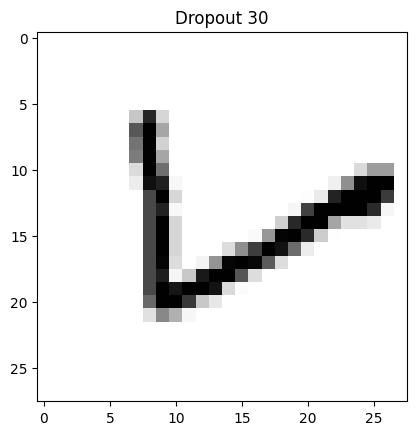

In [ ]:
for batch_idx, (image, target) in enumerate(test_loader):
  for i in range(len(image)):
    image = image[i, 0]
    image_tensor = image.unsqueeze(0).unsqueeze(0).to(device)

    plt.imshow(og_img, cmap='Greys');
    predictions=[]
    dropout_imgs = []

    for _ in range(30):
      with torch.no_grad():
        dropout_image = F.dropout(image_tensor, p =0.5, training = False)
        dropout_imgs.append(dropout_image)
        logits, probas = model2(dropout_image)
        predictions.append(torch.argmax(probas,dim=1).item())
        dropout_image_np = dropout_image.cpu().squeeze().numpy()
        plt.title('Dropout %d' % (_ + 1))
        plt.imshow(dropout_image_np, cmap='gray')
print("Predictions for the image with dropout:")
print(predictions)  # Print predictions
print("True label:", target[0])  # Print the true label of the image


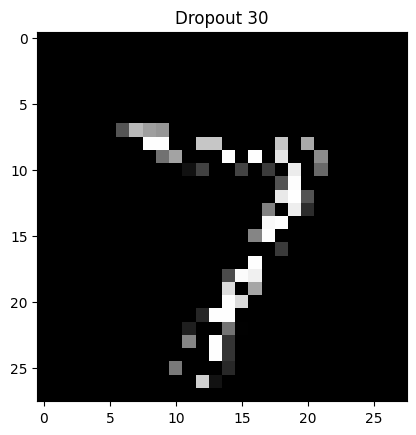

True label: 7



In [ ]:

num_images = 1  # Number of images to process
num_dropout = 30  # Number of dropout applications
for batch_idx, (images, targets) in enumerate(test_loader):  # Iterate through the test loader
    for i in range(num_images):  # Process specified number of images
        image = images[i, 0]  # Select the grayscale image from the batch
        image_tensor = image.unsqueeze(0).unsqueeze(0).to(device)  # Convert image to tensor and move it to the device

        # Original image
        #plt.subplot(num_images, num_dropout + 1, (num_dropout + 1) * i + 1)
        plt.title('Image')
        plt.imshow(image, cmap='gray')

        for j in range(num_dropout):  # Apply dropout specified number of times
            with torch.no_grad():  # Disable gradient calculation
                dropout_image = F.dropout(image_tensor, p=0.5, training=True)  # Apply dropout to the image
                logits, probas = model2(dropout_image)  # Forward pass with dropout
                dropout_image_np = dropout_image.cpu().squeeze().numpy()  # Convert to numpy array
                #plt.subplot(num_images, num_dropout + 1, (num_dropout + 1) * i + j + 2)
                plt.title('Dropout %d' % (j + 1))
                plt.imshow(dropout_image_np, cmap='gray')

        plt.show()

        print("True label:", targets[i].item())  # Print the true label of the image
        print()  # Add empty line for better readability

    break  # Break after processing the first batch (you can remove this line to process all batches)


In [ ]:
for image, target in test_loader:
  img = image.to(device)[0, None]  # Select the first image from the batch and move it to the device
  predictions = []  # List to store predictions
  image_p = np.transpose(image, axes=(1, 2, 0))
  image_p = np.squeeze(image_p.numpy(), axis=2)
  plt.subplot(1, 2, 1)
  plt.title('Original Image')
  plt.imshow(image, cmap='gray')

  for _ in range(30):  # Apply dropout 30 times
      with torch.no_grad():  # Disable gradient calculation
          dropout_image = F.dropout(image, p=0.5, training=True)  # Apply dropout to the image
          nhwc_img = np.transpose(dropout_image, axes=(1, 2, 0))
          dropout_image_np = dropout_image.cpu().squeeze().numpy()
          plt.subplot(1, 2, 2)
          plt.title('Dropout Image')
          plt.imshow(dropout_image_np, cmap='gray')
          logits, probas = model2(dropout_image)  # Forward pass with dropout
          predictions.append(torch.argmax(probas, dim=1).item())  # Append the predicted label to predictions

print("Predictions for the image with dropout:")
print(predictions)  # Print predictions
print("True label:", target[0])  # Print the true label of the image


ValueError: axes don't match array

In [ ]:
model2.eval()  # Set the model to evaluation mode
image, target = next(iter(test_loader))  # Get a batch of images and targets from the test loader
image = image.to(device)[0, None]  # Select the first image from the batch and move it to the device
predictions = []  # List to store predictions

for _ in range(30):  # Apply dropout 30 times
    with torch.no_grad():  # Disable gradient calculation
        logits, probas = model2(image)  # Forward pass with dropout
        predictions.append(torch.argmax(probas, dim=1).item())  # Append the predicted label to predictions

print("Predictions for the image with dropout:")
print(predictions)  # Print predictions
print("True label:", target[0])  # Print the true label of the image


Predictions for the image with dropout:
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
True label: tensor(7)


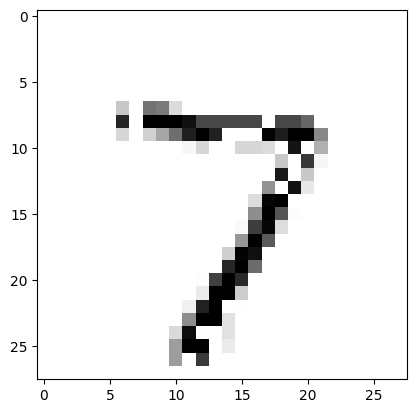

In [ ]:
dropout = nn.Dropout(p=0.3)
dropout_img = dropout(features[0])
dropout_img_p = np.transpose(dropout_img, axes=(1, 2, 0))
dropout_img_p = np.squeeze(dropout_img_p.numpy(), axis=2)
plt.imshow(dropout_img_p, cmap='Greys');

d_i_2 = dropout(features[1])
d_i = [dropout_img, d_i_2]

In [ ]:
out = model2(features)
o_p = model2(dropout_img.to(device)[0, None])

ValueError: expected 4D input (got 3D input)

In [ ]:
# Function to perform dropout multiple times on the same image
def apply_dropout(model, image, num_dropout=30):
    predictions = []
    dropout_images = []  # List to store images after dropout
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for _ in range(num_dropout):
            dropout = nn.Dropout(p=0.5)
            image_dropout = dropout(image)
            dropout_images.append(image_dropout)  # Append the image after dropout
            output = model(image_dropout)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())
    return predictions, dropout_images


In [ ]:
pred, img = apply_dropout(model2, features[0])

ValueError: expected 4D input (got 3D input)

ValueError: expected 4D input (got 3D input)

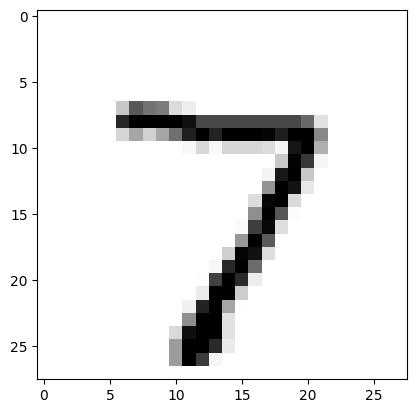

In [ ]:
for batch_idx, (features, targets) in enumerate(test_loader):
    features = features
    targets = targets
    for i in range(20):
        image = features[i]  # Assuming batch size is greater than 0
        nhwc_img = np.transpose(image, axes=(1, 2, 0))
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
        plt.imshow(nhw_img, cmap='Greys');
        # Apply dropout 30 times on the same image and get predictions
        predictions, dropout_images = apply_dropout(model2, image, num_dropout=30)
        print(predictions)

        # Display the image after dropout
        #for j, dropout_image in enumerate(dropout_images):
        #    dropout_image = dropout_image.squeeze().cpu().numpy()  # Convert tensor to numpy array
        #    plt.imshow(dropout_image, cmap='gray')
        #    plt.axis('off')  # Turn off axis
        #    plt.title(f'Image {i+1} after dropout {j+1}')
        #    plt.show()

        # Plot histogram of predictions
        plt.figure(figsize=(10, 6))
        plt.hist(predictions, bins=np.arange(11) - 0.5, color='skyblue', edgecolor='black', linewidth=1.2)
        plt.xticks(np.arange(10))
        plt.xlabel('Predicted Class')
        plt.ylabel('Frequency')
        plt.title('Histogram of Predicted Classes')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()



In [ ]:
# Get one batch of data from the valid loader
images = next(iter(test_loader))
images = torch.autograd.Variable(images[0])
print(images.shape)

# Select the first image from the batch
for i in range(20):
    image = images[i]  # Assuming batch size is greater than 0
    print(image.shape)

    # Convert the tensor to numpy array
    image_p = image.numpy()

    # Reshape the image to 28x28 (assuming MNIST dataset)
    image_p = image_p.reshape((28, 28))

    # Display the original image using matplotlib
    plt.imshow(image_p, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

    # Apply dropout 30 times on the same image and get predictions
    predictions, dropout_images = apply_dropout(model_ft, image.unsqueeze(0).to(device), num_dropout=30)
    print(predictions)

    # Display the image after dropout
    #for j, dropout_image in enumerate(dropout_images):
    #    dropout_image = dropout_image.squeeze().cpu().numpy()  # Convert tensor to numpy array
    #    plt.imshow(dropout_image, cmap='gray')
    #    plt.axis('off')  # Turn off axis
    #    plt.title(f'Image {i+1} after dropout {j+1}')
    #    plt.show()

    # Plot histogram of predictions
    plt.figure(figsize=(10, 6))
    plt.hist(predictions, bins=np.arange(11) - 0.5, color='skyblue', edgecolor='black', linewidth=1.2)
    plt.xticks(np.arange(10))
    plt.xlabel('Predicted Class')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Classes')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
